In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import os
from preprocess import merge_parquets, sample_dat

In [2]:
merge_data = pd.read_parquet('/Users/alex/Documents/2. NYU/DS-1007 Programming for Data Science/Project/DS1007_FinalProject/data/merge_data.parquet')

In [28]:
merge_data.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge', 'Airport_fee', 'date', 'hour',
       'time', 'temperature_2m (°C)', 'precipitation (mm)', 'rain (mm)',
       'snowfall (cm)', 'weather_cat'],
      dtype='object')

In [ ]:
# Step 3 Categorize Weather conditions

def categorize_weather(row):
    if row['precipitation (mm)'] > 0 and row['rain (mm)'] < 0 and row['snowfall (cm)'] < 0:
        return 'Light precipitation'
    elif row['precipitation (mm)'] > 0 and row['rain (mm)'] > 0 and row['snowfall (cm)'] < 0:
        return 'Precipitation'
    elif row['snowfall (cm)'] > 0:
        return "Snowfall"
    else:
        return "Clear day"

In [ ]:
conditions = [
    # Light precipitation: Precipitation > 0, Rain <= 0, Snowfall <= 0
    (merge_data['precipitation (mm)'] > 0) &
    (merge_data['rain (mm)'] <= 0) &
    (merge_data['snowfall (cm)'] <= 0),

    # Precipitation: Both precipitation and rain > 0, Snowfall <= 0
    (merge_data['precipitation (mm)'] > 0) &
    (merge_data['rain (mm)'] > 0) &
    (merge_data['snowfall (cm)'] <= 0),

    # Snowfall: Snowfall > 0
    (merge_data['snowfall (cm)'] > 0)
]

categories = [
    'Light precipitation',
    'Precipitation',
    'Snowfall'
]

merge_data['weather_cat'] = np.select(conditions, categories, default='Clear day')

# Filter rows where precipitation (mm) > 0 and display relevant columns
print(merge_data.loc[merge_data['precipitation (mm)'] > 0, ['precipitation (mm)', 'rain (mm)', 'snowfall (cm)', 'weather_cat']].head())



"""Vectorization avoids python looping optimizing run time and efficiency, that can improve large
dataset operations considerably
O(N*M)
vs
o(n)


	•	With .apply(axis=1):
	•	You loop through all 1 million rows, calling the function 1 million times.
	•	Time complexity: ~O(N) but with high constant factors due to Python loop overhead.
	•	With Vectorization (numpy.select):
	•	All conditions are evaluated column-wise in a single pass.
	•	Time complexity: ~O(N), but much faster due to C-level optimizations.
"""

        precipitation (mm)  rain (mm)  snowfall (cm)    weather_cat
251380                 1.9        1.9            0.0  Precipitation
251381                 1.9        1.9            0.0  Precipitation
251382                 1.9        1.9            0.0  Precipitation
251383                 1.9        1.9            0.0  Precipitation
251384                 1.9        1.9            0.0  Precipitation


'Vectorization avoids python looping optimizing run time and efficiency, that can improve large\ndataset operations considerably\nO(N*M)\nvs\no(n)\n\n\n\t•\tWith .apply(axis=1):\n\t•\tYou loop through all 1 million rows, calling the function 1 million times.\n\t•\tTime complexity: ~O(N) but with high constant factors due to Python loop overhead.\n\t•\tWith Vectorization (numpy.select):\n\t•\tAll conditions are evaluated column-wise in a single pass.\n\t•\tTime complexity: ~O(N), but much faster due to C-level optimizations.\n'

In [16]:
print(merge_data['weather_cat'].value_counts())

weather_cat
Clear day        32178185
Precipitation     5792191
Snowfall           339744
Name: count, dtype: int64


In [30]:
# Group by weather category and calculate ride frequency and average fare
weather_analysis = merge_data.groupby('weather_cat').agg({
    'tpep_pickup_datetime': 'count',  # Ride frequency
    'fare_amount': ['mean', 'sum'],  # Average and total fares
}).reset_index()

# Rename columns for clarity
weather_analysis.columns = ['weather_cat', 'ride_count', 'avg_fare', 'total_fare']

print(weather_analysis)

     weather_cat  ride_count   avg_fare    total_fare
0      Clear day    32178185  19.508426  6.277458e+08
1  Precipitation     5792191  19.697424  1.140912e+08
2       Snowfall      339744  17.840094  6.061065e+06


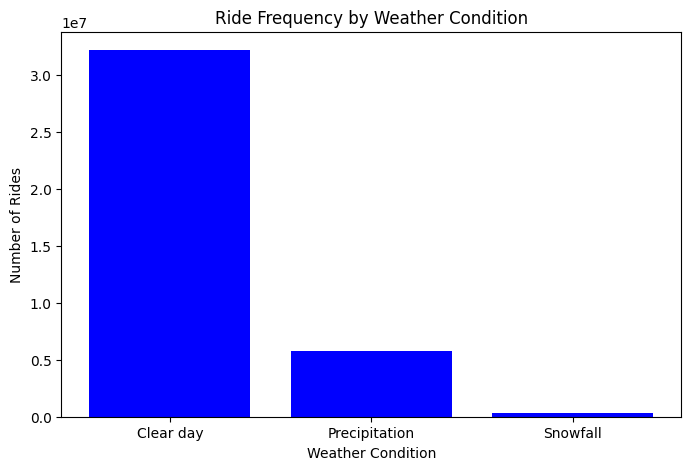

In [25]:
# Plot ride frequency
plt.figure(figsize=(8, 5))
plt.bar(weather_analysis['weather_cat'], weather_analysis['ride_count'], color='blue')
plt.xlabel('Weather Condition')
plt.ylabel('Number of Rides')
plt.title('Ride Frequency by Weather Condition')
plt.show()

In [33]:
# Add a column for ride proportions and average fares
weather_analysis['ride_proportion'] = weather_analysis['ride_count'] / weather_analysis['ride_count'].sum()
weather_analysis['fare_proportion'] = weather_analysis['total_fare'] / weather_analysis['total_fare'].sum()

print(weather_analysis)

     weather_cat  ride_count   avg_fare    total_fare  ride_proportion  \
0      Clear day    32178185  19.508426  6.277458e+08         0.839940   
1  Precipitation     5792191  19.697424  1.140912e+08         0.151192   
2       Snowfall      339744  17.840094  6.061065e+06         0.008868   

   fare_proportion  
0         0.839347  
1         0.152549  
2         0.008104  


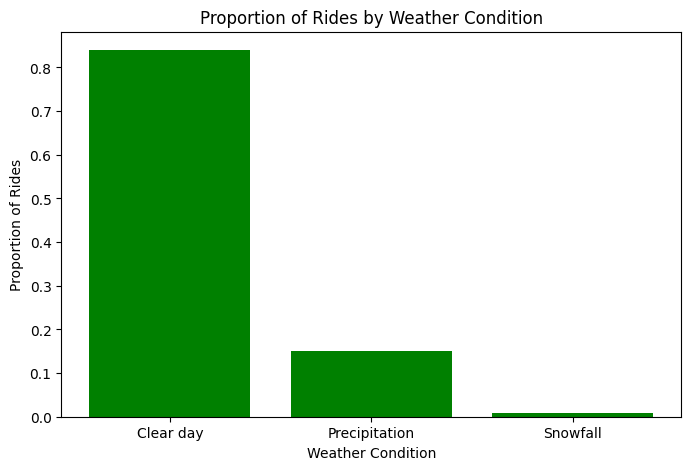

In [35]:
# Proportional bar plot
plt.figure(figsize=(8, 5))
plt.bar(weather_analysis['weather_cat'], weather_analysis['ride_proportion'], color='green')
plt.xlabel('Weather Condition')
plt.ylabel('Proportion of Rides')
plt.title('Proportion of Rides by Weather Condition')
plt.show()

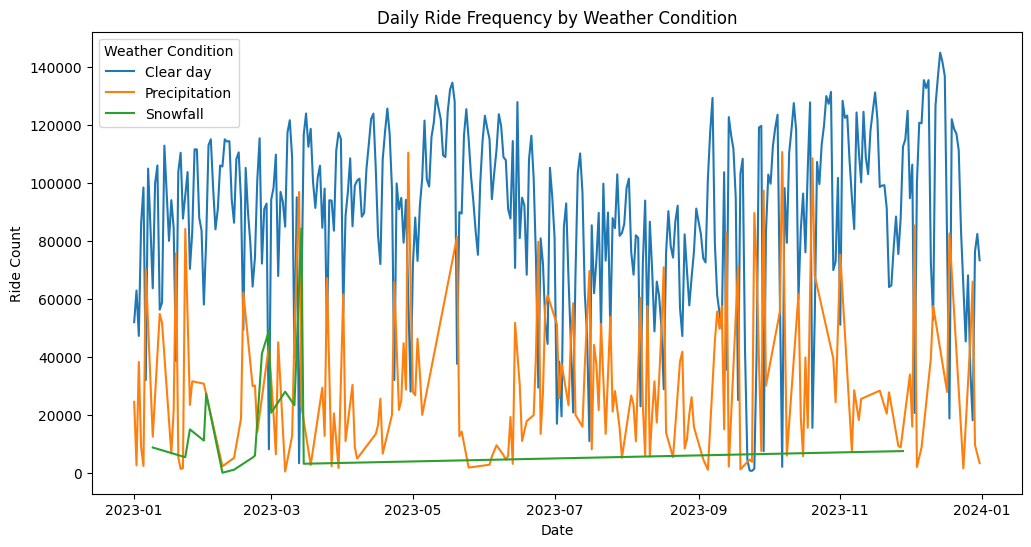

In [50]:
# Group by date and weather
daily_weather_analysis = merge_data.groupby(['date', 'weather_cat']).agg({
    'tpep_pickup_datetime': 'count',
    'fare_amount': 'mean'
}).reset_index()

# Plot trends over time
plt.figure(figsize=(12, 6))
sns.lineplot(data=daily_weather_analysis, x='date', y='tpep_pickup_datetime', hue='weather_cat')
plt.xlabel('Date')
plt.ylabel('Ride Count')
plt.title('Daily Ride Frequency by Weather Condition')
plt.legend(title='Weather Condition')
plt.show()

In [36]:
# Calculate median fare grouped by weather condition
median_fares = merge_data.groupby('weather_cat')['fare_amount'].median().reset_index(name='median_fare')

# Combine with weather_analysis
weather_analysis = weather_analysis.merge(median_fares, on='weather_cat')

print(weather_analysis)

     weather_cat  ride_count   avg_fare    total_fare  ride_proportion  \
0      Clear day    32178185  19.508426  6.277458e+08         0.839940   
1  Precipitation     5792191  19.697424  1.140912e+08         0.151192   
2       Snowfall      339744  17.840094  6.061065e+06         0.008868   

   fare_proportion  median_fare  
0         0.839347         13.5  
1         0.152549         13.5  
2         0.008104         12.8  


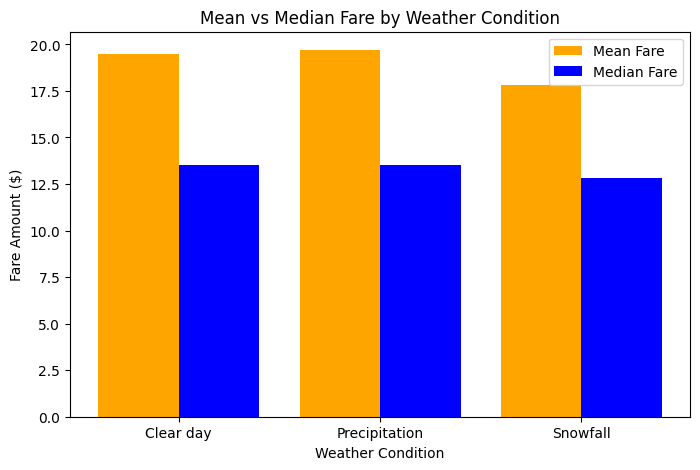

In [52]:
# Plot mean vs median fares
x = weather_analysis['weather_cat']
mean_fare = weather_analysis['avg_fare']
median_fare = weather_analysis['median_fare']

x_axis = range(len(x))

plt.figure(figsize=(8, 5))
plt.bar(x_axis, mean_fare, width=0.4, label='Mean Fare', color='orange')
plt.bar([i + 0.4 for i in x_axis], median_fare, width=0.4, label='Median Fare', color='blue')
plt.xticks([i + 0.2 for i in x_axis], x)
plt.xlabel('Weather Condition')
plt.ylabel('Fare Amount ($)')
plt.title('Mean vs Median Fare by Weather Condition')
plt.legend()
plt.show()

In [38]:
# Normalize by number of weather condition hours
weather_occurrences = merge_data.groupby('weather_cat')['time'].nunique().reset_index(name='weather_hours')

# Merge with weather_analysis
weather_analysis = weather_analysis.merge(weather_occurrences, on='weather_cat')
weather_analysis['rides_per_hour'] = weather_analysis['ride_count'] / weather_analysis['weather_hours']

print(weather_analysis)

     weather_cat  ride_count   avg_fare    total_fare  ride_proportion  \
0      Clear day    32178185  19.508426  6.277458e+08         0.839940   
1  Precipitation     5792191  19.697424  1.140912e+08         0.151192   
2       Snowfall      339744  17.840094  6.061065e+06         0.008868   

   fare_proportion  median_fare  weather_hours  rides_per_hour  
0         0.839347         13.5           7405     4345.467252  
1         0.152549         13.5           1283     4514.568200  
2         0.008104         12.8             71     4785.126761  


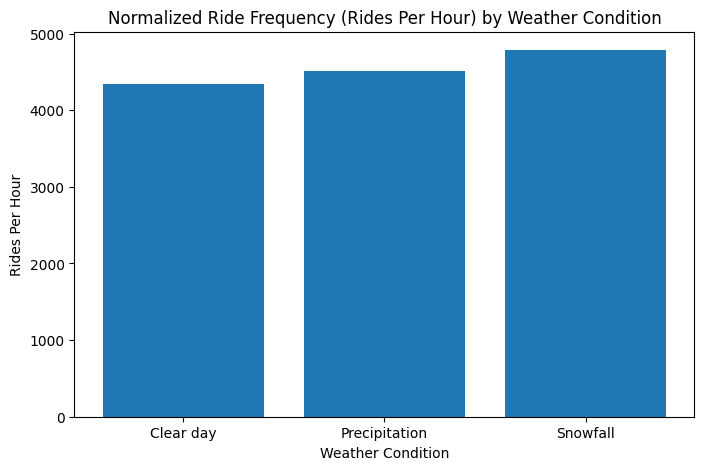

In [40]:
plt.figure(figsize=(8, 5))
plt.bar(weather_analysis['weather_cat'], weather_analysis['rides_per_hour'],)
plt.xlabel('Weather Condition')
plt.ylabel('Rides Per Hour')
plt.title('Normalized Ride Frequency (Rides Per Hour) by Weather Condition')
plt.show()

In [41]:
# Group by date and weather category
daily_weather = merge_data.groupby(['date', 'weather_cat']).agg({
    'tpep_pickup_datetime': 'count',  # Ride count
    'time': 'nunique'  # Number of weather hours in a day
}).reset_index()

# Normalize rides per weather hour
daily_weather['rides_per_hour'] = daily_weather['tpep_pickup_datetime'] / daily_weather['time']

print(daily_weather.head())

         date    weather_cat  tpep_pickup_datetime  time  rides_per_hour
0  2023-01-01      Clear day                 52109    17     3065.235294
1  2023-01-01  Precipitation                 24643     7     3520.428571
2  2023-01-02      Clear day                 63014    23     2739.739130
3  2023-01-02  Precipitation                  2763     1     2763.000000
4  2023-01-03      Clear day                 47366    15     3157.733333


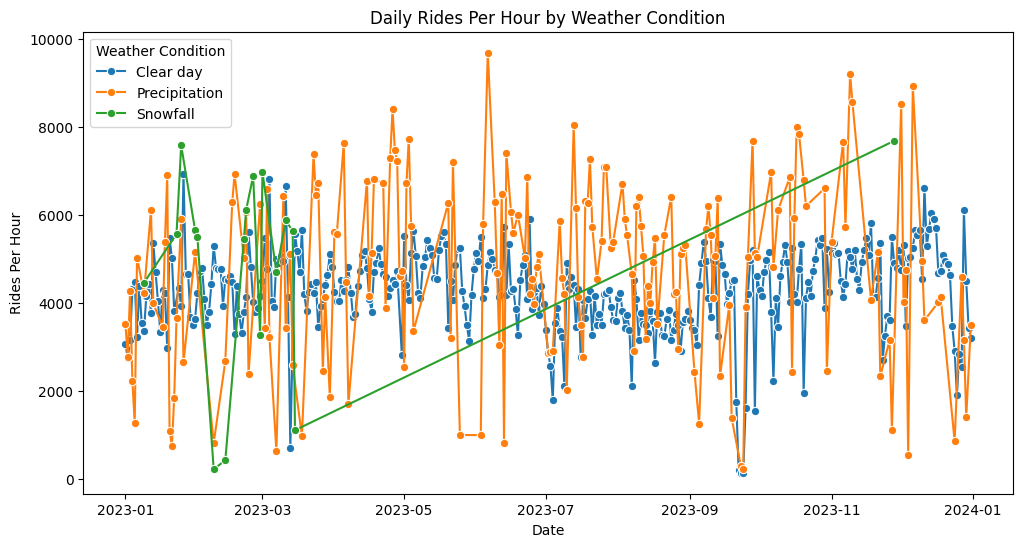

In [42]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=daily_weather, x='date', y='rides_per_hour', hue='weather_cat', marker='o')
plt.xlabel('Date')
plt.ylabel('Rides Per Hour')
plt.title('Daily Rides Per Hour by Weather Condition')
plt.legend(title='Weather Condition')
plt.show()

In [47]:
# Calculate z-scores for rides per hour
daily_weather['z_score'] = daily_weather.groupby('weather_cat')['rides_per_hour'].transform(
    lambda x: (x - x.mean()) / x.std()
)

daily_weather.head()

,date,weather_cat,tpep_pickup_datetime,time,rides_per_hour,z_score
0,2023-01-01,Clear day,52109,17,3065.235294,-1.272192
1,2023-01-01,Precipitation,24643,7,3520.428571,-0.601798
2,2023-01-02,Clear day,63014,23,2739.739130,-1.612910
3,2023-01-02,Precipitation,2763,1,2763.000000,-0.973780
4,2023-01-03,Clear day,47366,15,3157.733333,-1.175369


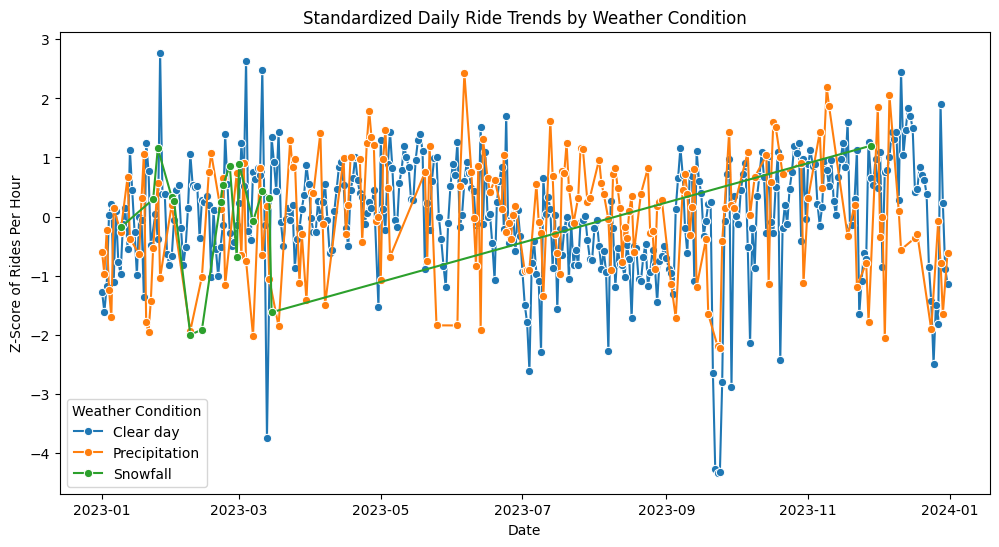

In [44]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=daily_weather, x='date', y='z_score', hue='weather_cat', marker='o')
plt.xlabel('Date')
plt.ylabel('Z-Score of Rides Per Hour')
plt.title('Standardized Daily Ride Trends by Weather Condition')
plt.legend(title='Weather Condition')
plt.show()

## Focus on January to March

In [45]:
# Filter data for the specified time period
selected_period = daily_weather[(daily_weather['date'] >= '2023-01-01') & (daily_weather['date'] <= '2023-03-15')]

print(selected_period.head())

TypeError: '>=' not supported between instances of 'datetime.date' and 'str'